Final Grade: 50/50

In [ ]:
%%bash
pip install pyspark &> /dev/null

data_file_1=listings.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/adityashah0112/Final-Project/main/${data_file_1} &> /dev/null
fi

In [ ]:
enable_grid_search = False

In [ ]:
#@title Libraries Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql import Row,SparkSession
from pyspark.sql.functions import regexp_replace,col,when,udf
from pyspark.sql.types import IntegerType, FloatType, DoubleType,StringType,BooleanType,DateType
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.tuning import ParamGridBuilder 
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.random import RandomRDDs

In [ ]:
spark = SparkSession.builder.appName("airbnb_host_growth").getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:
listing_df = pd.read_csv('/content/listings.csv')
schema = pd.io.json.build_table_schema(listing_df)['fields'][1:]

listing_df = listing_df.applymap(str)

Changing Data Type of Columns

In [ ]:
airbnb = (
    spark.createDataFrame(listing_df).replace('nan', None)
)
for i in schema:
    type_ = i['type']
    if type_=='number':
        type_='double'
    airbnb = airbnb.withColumn(i['name'],f.col(i['name']).cast(type_))

## Data Exploration

In [ ]:
airbnb.toPandas().shape

(3818, 92)

In [ ]:
airbnb.show(2)

+------+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+-------------+----------------------+----------------------------+-------+-----+-------+-------+--------------+------------+-------------+------------------+-------------------+-----------------+-------------+---------------+------------+---------+--------+----+--------+--------------------+-----------+-------+------------+---------

In [ ]:
airbnb.summary().show()

+-------+-----------------+--------------------+---------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+--------------------+--------------+----------------------+----------------------------+----------------+-----+------------------+-------+--------------------+------------+-------------+--------------------+-------------------+-----------------+-------------+---------------+------------------+---------------

In [ ]:
airbnb.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in airbnb.columns]).show()
airbnb.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in airbnb.columns]).show()

+---+-----------+---------+------------+----+-------+-----+-----------+-------------------+---------------------+-----+-------+-------------+----------+-----------+--------------+-------+--------+---------+----------+-------------+----------+------------------+------------------+--------------------+-----------------+------------------+----------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+------+-------------+----------------------+----------------------------+----+-----+-------+------+--------------+------------+-------+--------+---------+-----------------+-------------+---------+------------+---------+--------+----+--------+---------+-----------+-----+------------+-------------+----------------+------------+---------------+------------+--------------+--------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------+----------

## Data Cleaning
Removing % and $ sign from the columns

In [ ]:
def find_count(hv):
  try:
    return len(eval(hv))
  except:
    return 0
convertUDF = udf(lambda z: find_count(z),StringType())

In [ ]:
cols = ['id','description','name','host_response_time','host_response_rate','host_neighbourhood',
        'host_listings_count','host_total_listings_count','host_is_superhost','host_verifications','host_identity_verified',
        'neighbourhood_group_cleansed','zipcode','property_type','room_type','accommodates','bathrooms','bedrooms','beds','amenities','square_feet','price','weekly_price','monthly_price','security_deposit','cleaning_fee','guests_included','extra_people',
        'minimum_nights','maximum_nights','availability_30','availability_60','availability_90','availability_365',
        'number_of_reviews','cancellation_policy','reviews_per_month']

airbnb = (
    airbnb\
    .select(cols)\
    .withColumn("host_response_rate", regexp_replace("host_response_rate", "[^0-9a-zA-Z_\-]+", ""))\
    .withColumn("price", regexp_replace("price", "[$]+", "").cast('double').alias('price'))\
    .withColumn("weekly_price", regexp_replace("weekly_price", "[$]+", "").cast('double').alias('weekly_price'))\
    .withColumn("monthly_price", regexp_replace("monthly_price", "[$]+", "").cast('double').alias('monthly_price'))\
    .withColumn("security_deposit", regexp_replace("security_deposit", "[$]+", "").cast('double').alias('security_deposit'))\
    .withColumn("cleaning_fee", regexp_replace("cleaning_fee", "[$]+", "").cast('double').alias('cleaning_fee'))\
    .withColumn("extra_people", regexp_replace("extra_people", "[$]+", "").cast('double').alias('extra_people'))\
    .withColumn("amenities", regexp_replace("amenities", '(["}{]+)', "").alias('amenities'))
)


airbnb = (
    airbnb
    .withColumn("host_response_rate",airbnb.host_response_rate/100)
    .withColumn("encoded_cleaning_fee",
                f.when(f.col("cleaning_fee")==np.NaN,f.lit(0)).otherwise(f.lit(1))
                )
    .withColumn("security_deposit",
                f.when(f.col("security_deposit")==np.NaN,f.lit(0)).otherwise(f.col("security_deposit"))
                )
    .withColumn("bathrooms",
                f.when(f.col("bathrooms")==np.NaN,f.lit(1)).otherwise(f.col("bathrooms"))
                )
    .withColumn("bedrooms",
                f.when(f.col("bedrooms")==np.NaN,f.lit(1)).otherwise(f.col("bedrooms"))
                )
    .withColumn("beds",
                f.when(f.col("beds")==np.NaN,f.lit(1)).otherwise(f.col("beds"))
                )
    .withColumn('host_verifications_count',
                convertUDF(f.col('host_verifications')).cast('integer').alias('host_verifications_count'))
  )

In [ ]:
airbnb.show(1)

+------+--------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------------+-----------------+--------------------+----------------------+----------------------------+-------+-------------+---------------+------------+---------+--------+----+--------------------+-----------+-----+------------+-------------+----------------+------------+---------------+------------+--------------+--------------+---------------+---------------+---------------+----------------+-----------------+-------------------+-----------------+--------------------+------------------------+
|    id|         description|                name|host_response_time|host_response_rate|host_neighbourhood|host_listings_count|host_total_listings_count|host_is_superhost|  host_verifications|host_identity_verified|neighbourhood_group_cleansed|zipcode|property_type|      room_type|accommodates|bathrooms|bedrooms|beds|           amenities|square_feet|price|

In [ ]:
rows = airbnb.count()
columns = len(airbnb.columns)
print(f"DataFrame Rows count : {rows}" + f" and Columns : {columns}")

DataFrame Rows count : 3818 and Columns : 39


In [ ]:
from pyspark.sql.functions import isnan, isnull, when, count, col

airbnb.select([count(when(isnull(c), c)).alias(c) for c in airbnb.columns]).show()
airbnb.select([count(when(isnan(c), c)).alias(c) for c in airbnb.columns]).show()

+---+-----------+----+------------------+------------------+------------------+-------------------+-------------------------+-----------------+------------------+----------------------+----------------------------+-------+-------------+---------+------------+---------+--------+----+---------+-----------+-----+------------+-------------+----------------+------------+---------------+------------+--------------+--------------+---------------+---------------+---------------+----------------+-----------------+-------------------+-----------------+--------------------+------------------------+
| id|description|name|host_response_time|host_response_rate|host_neighbourhood|host_listings_count|host_total_listings_count|host_is_superhost|host_verifications|host_identity_verified|neighbourhood_group_cleansed|zipcode|property_type|room_type|accommodates|bathrooms|bedrooms|beds|amenities|square_feet|price|weekly_price|monthly_price|security_deposit|cleaning_fee|guests_included|extra_people|minimum_

## Data Visualization

In [ ]:
airbnb_pd_df = airbnb.toPandas()

In [ ]:
pt_dis = (
  airbnb
 .select('property_type','price')
 .groupBy('property_type')
 .agg(count("property_type").alias("count"),f.percentile_approx("price", 0.5).alias('median_price')) 
 .toPandas()
)
pt_dis = pt_dis.sort_values(by = "count",ascending = False)

ngc_dis = (
  airbnb
 .groupBy('neighbourhood_group_cleansed')
 .agg(count("neighbourhood_group_cleansed").alias("count"),f.percentile_approx("price", 0.5).alias('median_price')) 
 .toPandas()
)
ngc_dis = ngc_dis.sort_values(by = "count",ascending = False)

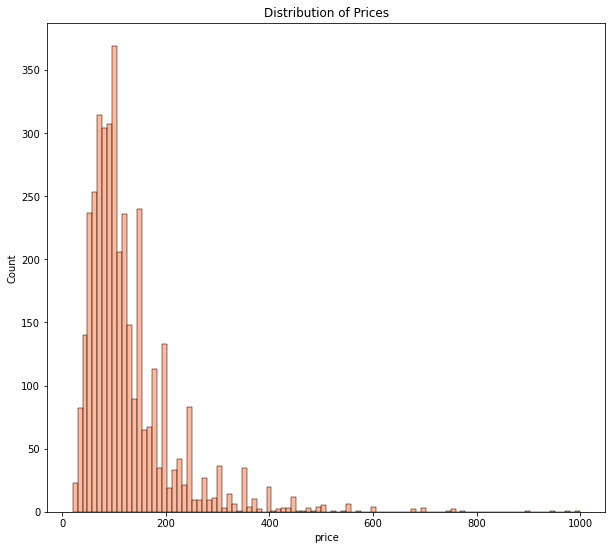

In [ ]:
plt.figure(figsize=(10,9))
sns.histplot(data = airbnb_pd_df,x='price',color = 'lightsalmon').set(title='Distribution of Prices')
plt.axvline(np.median(airbnb_pd_df.price),color='b', linestyle='--')

Text(0.5, 1.0, 'Coorelation between different variables')

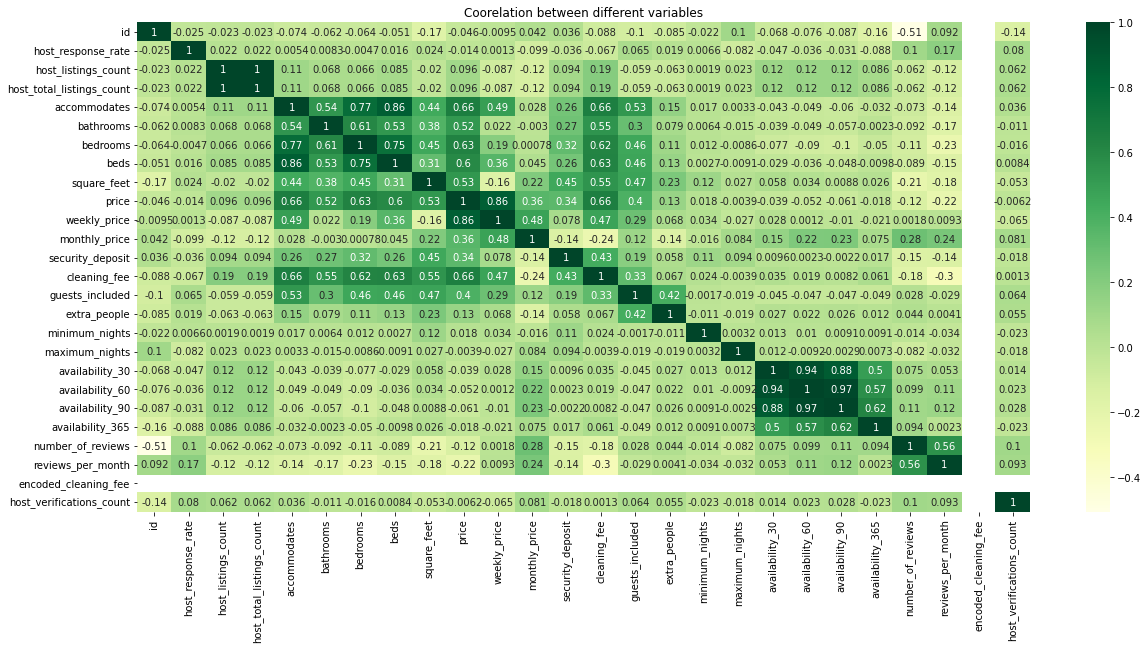

In [ ]:
plt.figure(figsize=(20,9))
corr = airbnb_pd_df.corr()
ax = sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values , cmap = 'YlGn' , annot=True)
ax.set_title("Coorelation between different variables")

Text(0.5, 1.0, 'Correlation between different variables')

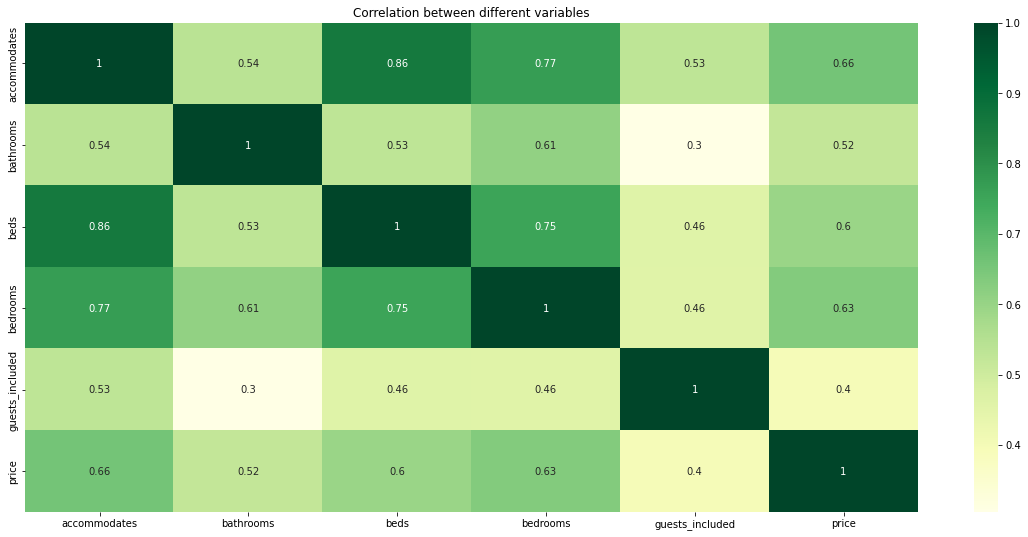

In [ ]:
cols = ['accommodates','bathrooms','beds','bedrooms','guests_included','price']
plt.figure(figsize=(20,9))
corr = airbnb_pd_df[cols].corr()
ax = sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values , cmap = 'YlGn' , annot=True)
ax.set_title("Correlation between different variables")

In [ ]:
def create_bar_plot(data,x,y,title,x_label,y_label):
  fig, ax2 = plt.subplots(figsize=(11, 5))

  sns.barplot(data=data, 
              x=x, 
              y=y,
              ax=ax2,
              palette=['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59'][::-1], 
              saturation=0.95)

  ax2.set_xticklabels(ax2.get_xticklabels())
  ax2.set_title(title)
  ax2.set_xlabel(x_label)
  ax2.set_ylabel(y_label)

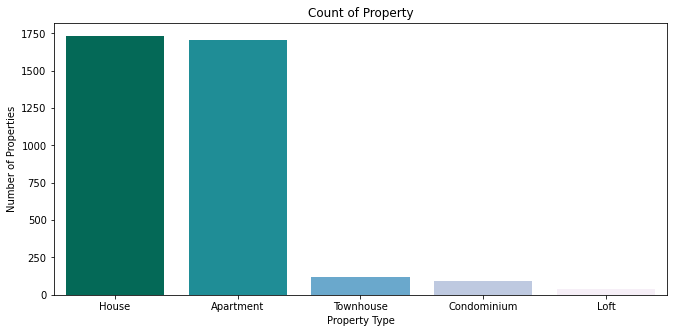

In [ ]:
create_bar_plot(pt_dis[:5],"property_type","count","Count of Property","Property Type","Number of Properties")

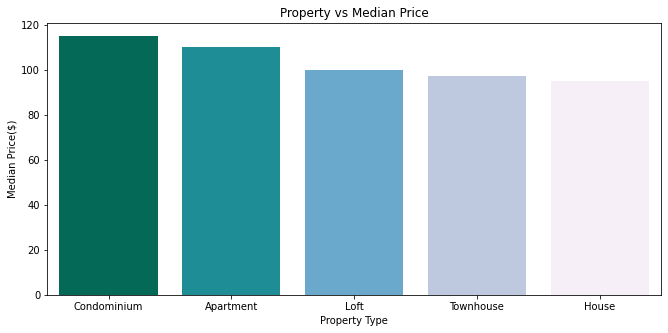

In [ ]:
create_bar_plot(pt_dis[:5].sort_values(by = "median_price",ascending = False),"property_type","median_price","Property vs Median Price","Property Type","Median Price($)")

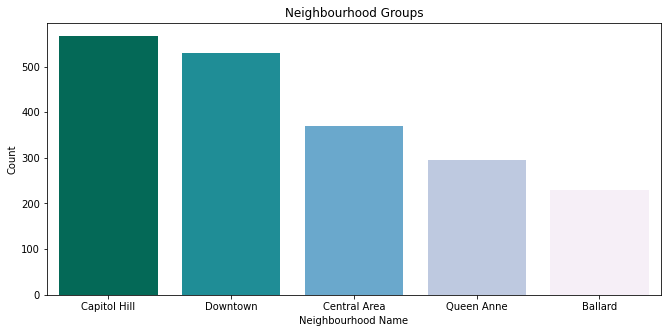

In [ ]:
create_bar_plot(ngc_dis[1:6],"neighbourhood_group_cleansed","count","Neighbourhood Groups","Neighbourhood Name","Count")

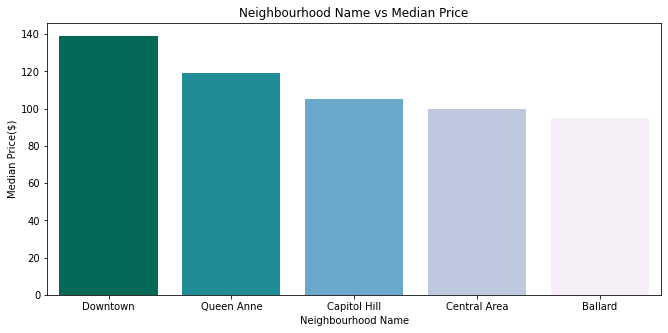

In [ ]:
create_bar_plot(ngc_dis[1:6].sort_values(by = "median_price",ascending = False),"neighbourhood_group_cleansed","median_price","Neighbourhood Name vs Median Price","Neighbourhood Name","Median Price($)")

Text(0, 0.5, 'price')

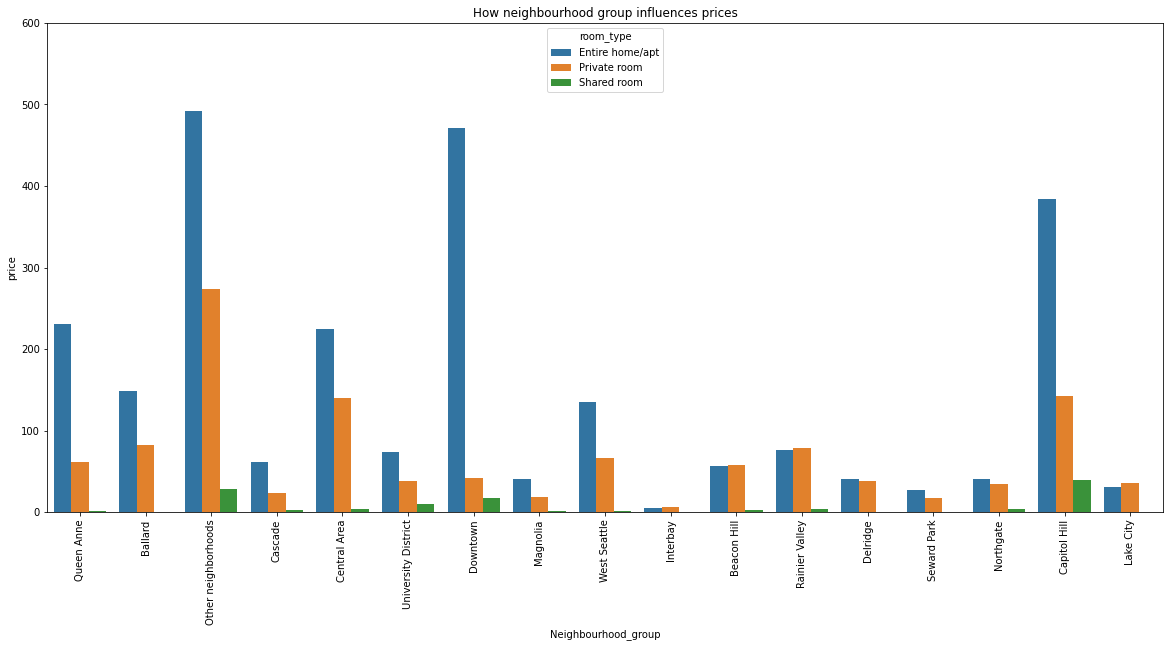

In [ ]:
plt.figure(figsize=(20,9))
# plt.rcParams.update({'font.size': 22})

ax2 = sns.countplot(data=airbnb_pd_df, x='neighbourhood_group_cleansed', hue='room_type')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylim(0, 600)
ax2.set_title("How neighbourhood group influences prices")
ax2.set_xlabel('Neighbourhood_group')
ax2.set_ylabel('price')

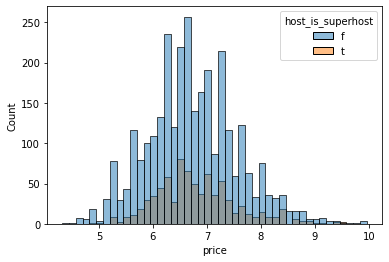

In [ ]:
airbnb_pd_df.dropna(subset=['price'], inplace=True)
airbnb_pd_df['price'] = pd.to_numeric(airbnb_pd_df['price'], errors="coerce", downcast='float').fillna(0)
airbnb_pd_df['price'] = np.log2(airbnb_pd_df['price'])
sns.histplot(data=airbnb_pd_df, x="price", hue="host_is_superhost")

In [ ]:
%%bash

# Download the data files from github

data_file_2=sentiments.parquet

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_2} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_2} 
fi


--2022-12-10 19:16:44--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/sentiments.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56439 (55K) [application/octet-stream]
Saving to: ‘sentiments.parquet’

     0K .......... .......... .......... .......... .......... 90% 6.79M 0s
    50K .....                                                 100% 33.3M=0.007s

2022-12-10 19:16:44 (7.33 MB/s) - ‘sentiments.parquet’ saved [56439/56439]



In [ ]:
sentiments_df =  spark.read.parquet('sentiments.parquet')

In [ ]:
from pyspark.sql.functions import regexp_replace
airbnb=airbnb.withColumn('description', regexp_replace('description', 'available', ' ')) 

In [ ]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("description")\
  .setOutputCol("words")

frequent_words_df = tokenizer.transform(airbnb)

frequent_words_df_1 = frequent_words_df.\
    select('id','price', f.explode('words').alias('word')).\
    join(sentiments_df, 'word')

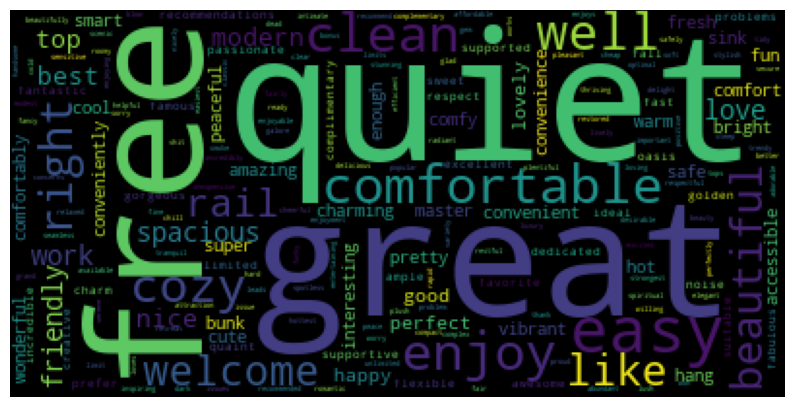

In [ ]:
frequent_words_df_2= frequent_words_df_1.filter(col("price") <= 75) 
fw= frequent_words_df_2.toPandas()
data = fw['word'].value_counts().to_dict()

wc = WordCloud().generate_from_frequencies(data)
plt.figure(figsize=(10, 8), dpi=100)
plt.imshow(wc)
plt.axis('off')
plt.show()

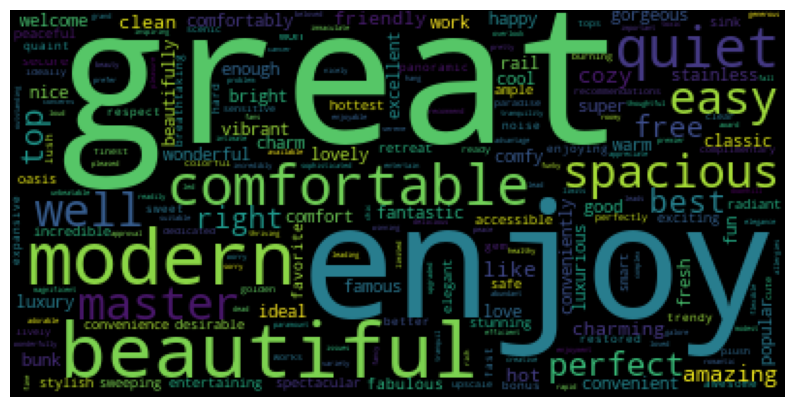

In [ ]:
frequent_words_df_3= frequent_words_df_1.filter(col("price") >= 150)
fw_1= frequent_words_df_3.toPandas()
data = fw_1['word'].value_counts().to_dict()

wc = WordCloud().generate_from_frequencies(data)
plt.figure(figsize=(10, 8), dpi=100)
plt.imshow(wc)
plt.axis('off')
plt.show()

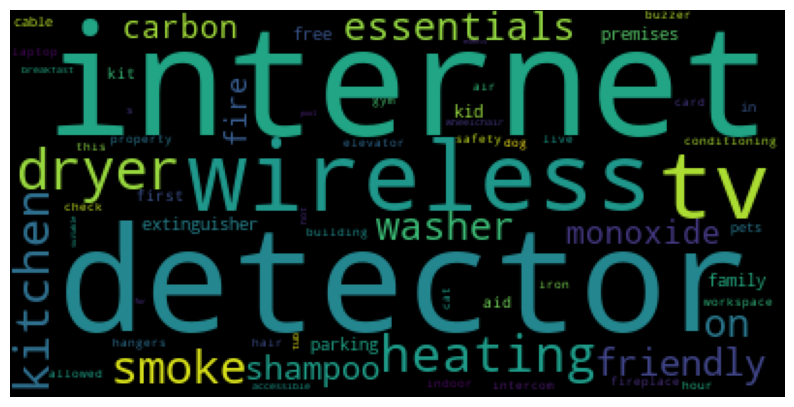

In [ ]:
new_amenities_df = airbnb.select('price','amenities')
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("amenities")\
  .setOutputCol("words")

review_words_df = tokenizer.transform(new_amenities_df)

pos = review_words_df.\
    select('price', f.explode('words').alias('word')).toPandas()
data = pos['word'].value_counts().to_dict()

from wordcloud import WordCloud, STOPWORDS

wc = WordCloud().generate_from_frequencies(data)
plt.figure(figsize=(10, 8), dpi=100)
plt.imshow(wc)
plt.axis('off')
plt.show()

## Data Modeling

In [ ]:
#@title Handling Amenities
amenities_df = airbnb.select('id', 'amenities').\
    withColumn('amenities_1', f.explode(f.split(f.col('amenities'), ','))).\
    withColumn('amenities_grouped', 
        f.when(f.col('amenities_1').like('%Internet%'), 'Internet').\
        when(f.col('amenities_1').like('%Washer%'), 'Washer').\
        when(f.col('amenities_1').like('%Dryer%'), 'Dryer').\
        when(f.col('amenities_1').like('%TV%'), 'TV').\
        when(f.lower(f.col('amenities_1')).like('%pet%'), 'Pets').\
        when(f.col('amenities_1').like('%Dog%'), 'Pets').\
        when(f.col('amenities_1').like('%Cat%'), 'Pets').\
        when(f.col('amenities_1').like('%Intercom%'), 'Intercom').\
        otherwise(f.col('amenities_1'))
        ).\
    withColumn('t', f.lit(1)).groupBy("id").pivot("amenities_grouped").\
    max('t').fillna(0).drop('')\
    .join(airbnb, ['id'])

#@title Final DataFrame
final_airbnb = amenities_df.drop('id')

In [ ]:
final_airbnb.show(1)

+----------------+----------------+---------+------------------------+-------+-----+--------------------+----------+-------------------+-----------------+-------------+------------------------+---+-------+-------+-------+----------------+--------+--------+----+-------+-------------------------+--------------------+----+----+-----------+-------+--------------+---------------+-------------------+---+------+---------------------+--------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------------+-----------------+--------------------+----------------------+----------------------------+-------+-------------+---------------+------------+---------+--------+----+--------------------+-----------+-----+------------+-------------+----------------+------------+---------------+------------+--------------+--------------+---------------+---------------+---------------+----------------+-----------------+-------------------+-

In [ ]:
#@title String Indexing and One Hot Encoding

#host_reponse_time
hrt_num = feature.StringIndexer(inputCol='host_response_time', handleInvalid='skip', outputCol='encoded_host_response_time')
hrt_ohe = feature.OneHotEncoder(inputCol='encoded_host_response_time', outputCol = "one_hot_embarked_host_response_time")

#neighbourhood_group_cleansed
ngc_num = feature.StringIndexer(inputCol='neighbourhood_group_cleansed', handleInvalid='skip', outputCol='encoded_neighbourhood_group_cleansed')
ngc_ohe = feature.OneHotEncoder(inputCol='encoded_neighbourhood_group_cleansed', outputCol = "one_hot_embarked_neighbourhood_group_cleansed")

#host_is_superhost
his_num = feature.StringIndexer(inputCol='host_is_superhost', handleInvalid='skip', outputCol='encoded_host_is_superhost')

#host_identity_verified
hiv_num = feature.StringIndexer(inputCol='host_identity_verified', handleInvalid='skip', outputCol='encoded_host_identity_verified')

#property_type
pt_num = feature.StringIndexer(inputCol='property_type', handleInvalid='skip', outputCol='encoded_property_type')
pt_ohe = feature.OneHotEncoder(inputCol='encoded_property_type', outputCol = "one_hot_embarked_property_type")

#room_type
rt_num = feature.StringIndexer(inputCol='room_type', handleInvalid='skip', outputCol='encoded_room_type')
rt_ohe = feature.OneHotEncoder(inputCol='encoded_room_type', outputCol = "one_hot_embarked_room_type")

#cancellation_policy
cp_num = feature.StringIndexer(inputCol='cancellation_policy', handleInvalid='skip', outputCol='encoded_cancellation_policy')
cp_ohe = feature.OneHotEncoder(inputCol='encoded_cancellation_policy', outputCol = "one_hot_embarked_cancellation_policy")

In [ ]:
def get_mse_r2(pipe,train,test):
  pipe_model_fitted = pipe.fit(train)
  #transformed_airbnb = pipe_model_fitted.transform(test) 
  mse = f.mean((f.col('price') - f.col('prediction'))**2).alias('mse')
  val_mse = pipe_model_fitted.transform(test).select(mse).first()[0]

  evaluator = RegressionEvaluator(labelCol='price',predictionCol="prediction",metricName= 'r2')
  val_r2 = evaluator.evaluate(pipe_model_fitted.transform(test))
  return val_mse,val_r2,pipe_model_fitted

### Prediction and Inference of Listing Price

#### Linear Regression

In [ ]:
bool_cols = ['host_is_superhost', 'host_identity_verified', 'security_deposit', 'cleaning_fee', 'extra_people']

def convert_to_bool(c1):
    if c1 in (None, 0, 0.0, 'null', 'f', False):
        return 0
    return 1

booler = f.udf(convert_to_bool, IntegerType())

for i in bool_cols:
    airbnb_LR = final_airbnb.withColumn(f'bool_{i}', booler(f.col(i)))

airbnb_LR = final_airbnb.withColumn('more_guests_than_beds', booler(f.col('guests_included')>f.col('beds')))


In [ ]:
int_cols = [x['name'] for x in pd.io.json.build_table_schema(airbnb_LR.toPandas())['fields'][1:] if x['type'] in ('integer', 'double', 'number') and x['name'] != 'price']
string_index_cols = ['host_response_time', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'cancellation_policy']

In [ ]:
def pipeline_builder(int_cols, string_index_cols, final):
    encoded_stages = [] 
    onehot_stages = []
    encoded_inputs = []
    onehot_inputs = []

    for i in string_index_cols:
        new_col_name = f'encoded_{i}'
        encoded_inputs.append(new_col_name)
        
        onehot_col = f'onehot_{i}'
        onehot_inputs.append(onehot_col)

        encoded_stages.append(feature.StringIndexer(inputCol=i, handleInvalid='skip', outputCol=new_col_name))
        onehot_stages.append(feature.StringIndexer(inputCol=i, handleInvalid='skip', outputCol=new_col_name))
        onehot_stages.append(feature.OneHotEncoder(inputCol=new_col_name, outputCol = onehot_col))

    encoded_inputs.extend(int_cols)
    encoded_stages.append(feature.VectorAssembler(inputCols=encoded_inputs, outputCol='features'))
    encoded_stages.append(feature.StandardScaler(withMean=True, inputCol='features', outputCol='features_scaled'))
    encoded_stages.append(final)
    
    onehot_inputs.extend(int_cols)
    onehot_stages.append(feature.VectorAssembler(inputCols=onehot_inputs, outputCol='features'))
    onehot_stages.append(feature.StandardScaler(withMean=True, inputCol='features', outputCol='features_scaled'))
    onehot_stages.append(final)

    return encoded_stages, onehot_stages, encoded_inputs, onehot_inputs

In [ ]:
lr = LinearRegression(featuresCol='features_scaled', labelCol='price')

encoded_stages, onehot_stages, encoded_inputs, onehot_inputs = pipeline_builder(int_cols, string_index_cols, lr)

train, val, test = airbnb_LR.fillna(0).randomSplit([.6, .2, .2], seed=42)

lr_pipe_encoded = Pipeline(stages=encoded_stages)
lr_pipe_onehot = Pipeline(stages=onehot_stages)

In [ ]:
if enable_grid_search:
    grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0.4, 0.5, 0.6]).\
    addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4]).\
    build()

    all_models = []
    for j in tqdm(range(len(grid))):
        model = lr_pipe_encoded.fit(train, grid[j])
        all_models.append(model)

    lr_mse_calculation = [m.\
        transform(test).\
        select(f.avg(f.expr('float(price-prediction)*float(price-prediction)')).alias('mse')).\
        first().\
        mse for m in all_models]

    lr_best_model_idx = np.argmin(lr_mse_calculation)
    print(f'Best model index: {lr_best_model_idx}')

    lr_best_model = all_models[lr_best_model_idx]
    
    [print(f'Best model param - {i.name} : {j}') for i, j in zip(grid[lr_best_model_idx].keys(), grid[lr_best_model_idx].values())]

    lr_best_model.\
    transform(val).\
    select(f.avg(f.expr('float(price-prediction)*float(price-prediction)')).alias('mse')).\
    show(truncate=False)


In [ ]:
evaluator = evaluation.RegressionEvaluator(predictionCol="prediction", labelCol="price")

In [ ]:
# Your code here
indexed_stages, _, indexed_inputs, _ = pipeline_builder(
    int_cols, 
    string_index_cols, 
    final = LinearRegression(
        featuresCol='features_scaled', 
        labelCol='price',
        regParam=0.5,
        elasticNetParam=0.0
    )
)
best_lr_indexed_pipe = Pipeline(stages= indexed_stages)


In [ ]:
best_lr_indexed_model = best_lr_indexed_pipe.fit(train)
best_lr_indexed_df = best_lr_indexed_model.transform(val)

best_lr_indexed_model_mse= evaluator.evaluate(best_lr_indexed_df, {evaluator.metricName: 'mse'})
print(f"MSE results from String Indexed model: {best_lr_indexed_model_mse}")

best_lr_indexed_model_r2= evaluator.evaluate(best_lr_indexed_df, {evaluator.metricName: 'r2'})
print(f"R-sq results from String Indexed model: {best_lr_indexed_model_r2}")

MSE results from String Indexed model: 2737.5141227462145
R-sq results from String Indexed model: 0.47330164493631555


In [ ]:
if enable_grid_search:
    grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0.4, 0.7]).\
    addGrid(lr.elasticNetParam, [0.0, 0.2]).\
    build()

    all_models = []
    for j in tqdm(range(len(grid))):
        model = lr_pipe_onehot.fit(train, grid[j])
        all_models.append(model)

    mse_calculation = [m.\
        transform(val).\
        select(f.avg(f.expr('float(price-prediction)*float(price-prediction)')).alias('mse')).\
        first().\
        mse for m in all_models]

    ohe_best_model_idx = np.argmin(mse_calculation)
    print(f'Best model index: {ohe_best_model_idx}')

    ohe_best_model = all_models[ohe_best_model_idx]
    
    [print(f'Best model param - {i.name} : {j}') for i, j in zip(grid[ohe_best_model_idx].keys(), grid[ohe_best_model_idx].values())]

    ohe_best_model.\
    transform(val).\
    select(f.avg(f.expr('float(price-prediction)*float(price-prediction)')).alias('mse')).\
    show()


In [ ]:
_, onehot_stages, _, _ = pipeline_builder(
    int_cols, 
    string_index_cols, 
    final = LinearRegression(
        featuresCol='features_scaled', 
        labelCol='price',
        regParam=0.7,
        elasticNetParam=0.0
    )
)
best_lr_onehot_pipe = Pipeline(stages= onehot_stages)

In [ ]:
best_lr_onehot_model = best_lr_onehot_pipe.fit(train)
best_lr_onehot_df = best_lr_onehot_model.transform(val)

onehot_encoded_model_mse= evaluator.evaluate(best_lr_onehot_df, {evaluator.metricName: 'mse'})
print(f"MSE results from onehot encoded model: {onehot_encoded_model_mse}")

onehot_encoded_model_r2= evaluator.evaluate(best_lr_onehot_df, {evaluator.metricName: 'r2'})
print(f"R-sq results from onehot encoded model: {onehot_encoded_model_r2}")

MSE results from onehot encoded model: 3429.14018548946
R-sq results from onehot encoded model: 0.4782787440617383


In [ ]:
indexed_vs_onehot_lr_compare = pd.DataFrame([
                            [best_lr_indexed_model_mse, best_lr_indexed_model_r2],
                            [onehot_encoded_model_mse, onehot_encoded_model_r2]
                        ],
                        columns=['MSE', 'R2'],
                        index=['Indexed','Onehot']
                    )
indexed_vs_onehot_lr_compare

,MSE,R2
Indexed,2737.514123,0.473302
Onehot,3429.140185,0.478279


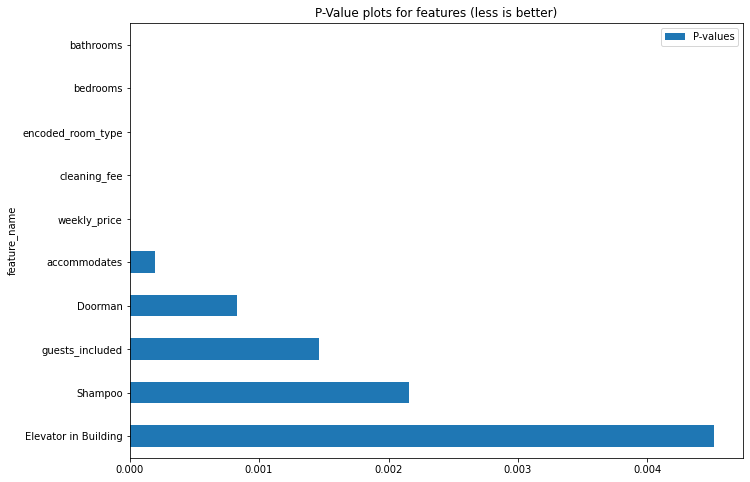

In [ ]:
pd.DataFrame({
    'feature_name': indexed_inputs,
    'P-values': best_lr_indexed_model.stages[-1].summary.pValues[:-1]}).sort_values(by=['P-values'], ascending=False).iloc[-10:].plot.barh(x='feature_name', y='P-values', title = 'P-Value plots for features (less is better)', figsize=(11,8))


In [ ]:
best_lr_onehot_model.stages[-1].summary.pValues, train.columns, columns=['Feature', 'Coefficient']).sort_values(by=['Coefficient'])


#### Random Forest Regressor

In [ ]:
#@title Selecting columns for RF
mod_cols = ['host_response_time','host_response_rate','host_listings_count','host_is_superhost','host_identity_verified',
            'neighbourhood_group_cleansed','property_type','room_type','accommodates','bathrooms','bedrooms','beds','guests_included',
            'extra_people','minimum_nights','number_of_reviews','cancellation_policy','reviews_per_month','encoded_cleaning_fee','host_verifications_count','24-Hour Check-in', 
            'Air Conditioning', 'Breakfast', 'Carbon Monoxide Detector', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 
            'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Intercom', 'Internet', 
            'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Pets', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 
            'Suitable for Events', 'TV', 'Washer', 'Wheelchair Accessible',
            'price']

airbnb_mod = (
    final_airbnb
    .select(mod_cols)
)

In [ ]:
training_df, validation_df, testing_df = airbnb_mod.randomSplit([0.6, 0.3, 0.1],seed = 20)

In [ ]:
#@title RF51
temp = ['host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included','extra_people',
        'minimum_nights','number_of_reviews','encoded_cleaning_fee','host_verifications_count',
        '24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Carbon Monoxide Detector', 'Doorman', 'Dryer', 'Elevator in Building', 
        'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hangers', 
        'Heating', 'Hot Tub', 'Indoor Fireplace', 'Intercom', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 
        'Lock on Bedroom Door', 'Pets', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 
        'Suitable for Events', 'TV', 'Washer', 'Wheelchair Accessible',
        'encoded_host_response_time','encoded_host_is_superhost','encoded_neighbourhood_group_cleansed','encoded_host_identity_verified',
        'encoded_property_type','encoded_room_type','encoded_cancellation_policy']

first_pipe = Pipeline(stages=[
    hrt_num,ngc_num,ngc_ohe,his_num,hiv_num,pt_num,pt_ohe,rt_num,rt_ohe,cp_num,cp_ohe,
    feature.VectorAssembler(inputCols=temp, 
                            outputCol='features',handleInvalid='skip')
])

first_sc = feature.StandardScaler(withMean=True,inputCol='features', outputCol='zfeatures')

first_rf = regression.RandomForestRegressor(featuresCol='zfeatures', labelCol='price')
first_rf_pipe = Pipeline(stages=[first_pipe,first_sc,first_rf])

first_val_mse, first_val_r2, rf_pipe_model_fitted = get_mse_r2(first_rf_pipe,training_df,validation_df)
print("mse: " + str(first_val_mse))
print("r2: " + str(first_val_r2))


rf_model = rf_pipe_model_fitted.stages[-1]
rf_featureImportance = pd.DataFrame(list(zip(temp, rf_model.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False)

mse: 2325.66510461497
r2: 0.6378098357851474


In [ ]:
#@title RF23 after removing columns
temp = ['host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included','extra_people',
        'minimum_nights','number_of_reviews','host_verifications_count','Air Conditioning','Doorman', 'Elevator in Building', 
        'Family/Kid Friendly', 'Gym', 'Hot Tub', 'Pool', 'Suitable for Events', 
        'encoded_host_response_time','encoded_neighbourhood_group_cleansed',
        'encoded_property_type','encoded_room_type','encoded_cancellation_policy']

second_pipe = Pipeline(stages=[
    hrt_num,ngc_num,ngc_ohe,his_num,hiv_num,pt_num,pt_ohe,rt_num,rt_ohe,cp_num,cp_ohe,
    feature.VectorAssembler(inputCols=temp, 
                            outputCol='features',handleInvalid='skip')
])

second_sc = feature.StandardScaler(withMean=True,inputCol='features', outputCol='zfeatures')

second_rf = regression.RandomForestRegressor(featuresCol='zfeatures', labelCol='price')
second_rf_pipe = Pipeline(stages=[second_pipe,second_sc,second_rf])

second_val_mse, second_val_r2, second_rf_pipe_model_fitted = get_mse_r2(second_rf_pipe,training_df,validation_df)
print("mse: " + str(second_val_mse))
print("r2: " + str(second_val_r2))

second_rf_model = second_rf_pipe_model_fitted.stages[-1]
second_rf_feature_importance = pd.DataFrame(list(zip(temp, second_rf_model.featureImportances.toArray())),
            columns = ['feature_name', 'weight']).sort_values('weight',ascending = False)

mse: 2313.7244201521207
r2: 0.6396694321895716


In [ ]:
#@title GridSearch
if enable_grid_search:
  grid = ParamGridBuilder().\
          addGrid(second_rf.numTrees, [5,10,15,20,30]).\
          addGrid(second_rf.maxDepth, [10,15,20]).\
          build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = second_rf_pipe.fit(training_df, grid[j])
      all_models.append(model)

  accuracies = [m.\
                transform(testing_df).\
                select(f.mean((f.col('price') - f.col('prediction'))**2).alias('mse')).\
                first().\
                mse for m in all_models]

  best_model_idx = np.argmin(accuracies)

  print(grid[best_model_idx])
  print(accuracies[best_model_idx])

In [ ]:
#@title RFGrid
# temp = ['host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included','extra_people',
#         'minimum_nights','number_of_reviews','encoded_cleaning_fee','host_verifications_count',
#         '24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Carbon Monoxide Detector', 'Doorman', 'Dryer', 'Elevator in Building', 
#         'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hangers', 
#         'Heating', 'Hot Tub', 'Indoor Fireplace', 'Intercom', 'Internet', 'Iron', 'Kitchen', 'Laptop Friendly Workspace', 
#         'Lock on Bedroom Door', 'Pets', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 
#         'Suitable for Events', 'TV', 'Washer', 'Wheelchair Accessible',
#         'encoded_host_response_time','encoded_host_is_superhost','encoded_neighbourhood_group_cleansed','encoded_host_identity_verified',
#         'encoded_property_type','encoded_room_type','encoded_cancellation_policy']


temp = ['host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included','extra_people',
        'minimum_nights','number_of_reviews','host_verifications_count',
        'Air Conditioning','Doorman', 'Elevator in Building', 
        'Family/Kid Friendly', 'Gym', 
        'Hot Tub','Pool', 
        'Suitable for Events', 
        'encoded_host_response_time','encoded_neighbourhood_group_cleansed',
        'encoded_property_type','encoded_room_type','encoded_cancellation_policy']


best_pipe = Pipeline(stages=[
    hrt_num,ngc_num,ngc_ohe,his_num,hiv_num,pt_num,pt_ohe,rt_num,rt_ohe,cp_num,cp_ohe,
    feature.VectorAssembler(inputCols=temp, 
                            outputCol='features',handleInvalid='skip')
])
best_sc = feature.StandardScaler(withMean=True,inputCol='features', outputCol='zfeatures')
best_rf = regression.RandomForestRegressor(featuresCol='zfeatures', labelCol='price',numTrees=30,maxDepth=15)
best_rf_pipe = Pipeline(stages=[best_pipe,best_sc, best_rf])

best_val_mse, best_val_r2, best_rf_pipe_model_fitted = get_mse_r2(best_rf_pipe,training_df,validation_df)
print("mse: " + str(best_val_mse))
print("r2: " + str(best_val_r2))

best_rf_model = best_rf_pipe_model_fitted.stages[-1]
best_rf_feature_importance = pd.DataFrame(list(zip(temp, best_rf_model.featureImportances.toArray())),
            columns = ['feature_name', 'weight']).sort_values('weight',ascending = False)

mse: 2308.4641871962126
r2: 0.6404886406965609


In [ ]:
# test_val_mse, test_val_r2, test_best_rf_pipe_model_fitted = get_mse_r2(best_rf_pipe,training_df,training_df)
# print("mse: " + str(test_val_mse))
# print("r2: " + str(test_val_r2))

# test_val_mse, test_val_r2, test_best_rf_pipe_model_fitted = get_mse_r2(best_rf_pipe,training_df,testing_df)
# print("mse: " + str(test_val_mse))
# print("r2: " + str(test_val_r2))

In [ ]:
rf_model1_mse_compare = pd.DataFrame(list(zip(['RF51','RF23','RFGrid'], [first_val_mse,second_val_mse,best_val_mse],[first_val_r2,second_val_r2,best_val_r2])),
            columns = ['Model', 'Validation MSE', 'Validation R2'])
rf_model1_mse_compare

,Model,Validation MSE,Validation R2
0,RF51,2325.665105,0.637810
1,RF23,2313.724420,0.639669
2,RFGrid,2308.464187,0.640489


In [ ]:
best_rf_feature_importance[:10]

,feature_name,weight
3,bedrooms,0.160853
1,accommodates,0.158151
2,bathrooms,0.135543
21,encoded_room_type,0.081368
4,beds,0.064683
8,number_of_reviews,0.047866
0,host_listings_count,0.044601
5,guests_included,0.038772
19,encoded_neighbourhood_group_cleansed,0.034223
6,extra_people,0.033251


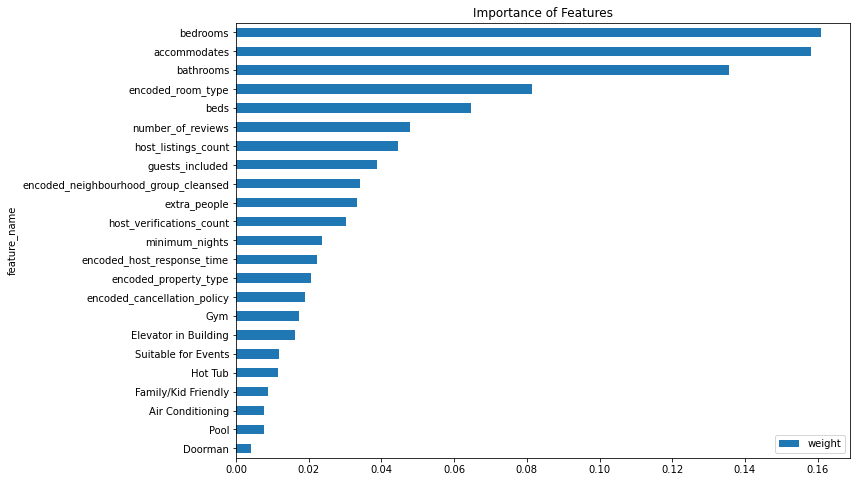

In [ ]:
best_rf_feature_importance.sort_values(by='weight',ascending = True).plot.barh(x='feature_name',y='weight',title = 'Importance of Features',figsize=(11,8))

### Classification of Superhost

#### Random Forest Classifier

In [ ]:
sampled_final_airbnb = final_airbnb.sampleBy("host_is_superhost",fractions={'f':0.23,'t':0.91}, seed = 123)
sampled_final_airbnb = (sampled_final_airbnb.withColumn("host_is_superhost01",f.when(f.col("host_is_superhost")=='f',f.lit(0)).otherwise(f.lit(1))))

training_df, validation_df, testing_df = sampled_final_airbnb.randomSplit([0.6, 0.2, 0.2],)

In [ ]:
#@title Random Forest Classifier
temp = ['host_response_rate','host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included',
            'extra_people','minimum_nights','maximum_nights','availability_30','number_of_reviews','reviews_per_month',
            '24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Carbon Monoxide Detector', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 
            'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Intercom', 'Internet', 
            'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Pets', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 
            'Suitable for Events', 'TV', 'Washer', 'Wheelchair Accessible','price',
            'encoded_host_response_time','encoded_neighbourhood_group_cleansed','encoded_host_identity_verified',
            'encoded_property_type','encoded_room_type','encoded_cancellation_policy']

second_pipe = Pipeline(stages=[
    hrt_num,ngc_num,hiv_num,pt_num,rt_num,cp_num,
    feature.VectorAssembler(inputCols=temp, 
                            outputCol='features',handleInvalid='skip')
])

rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='host_is_superhost01')
rf_classifier_pipe = Pipeline(stages=[second_pipe, rf_classifier])
rf_classifier_pipe_model_fitted = rf_classifier_pipe.fit(training_df)

accuracy = f.avg(f.expr('float(host_is_superhost01 = prediction)')).alias('accuracy')
rfc_val_auc = rf_classifier_pipe_model_fitted.transform(validation_df).select(accuracy).first()[0]

In [ ]:
#@title Grid Builder for RF Classifier
if enable_grid_search:
    grid = ParamGridBuilder().addGrid(rf_classifier.numTrees, [10,20,30]).addGrid(rf_classifier.maxDepth, [4,5]).build()

    all_models = []
    for j in range(len(grid)):
        print("Fitting model {}".format(j+1))
        model = rf_classifier_pipe.fit(training_df, grid[j])
        all_models.append(model)

    accuracies = [m.\
                  transform(validation_df).\
                  select(f.avg(f.expr('float(host_is_superhost01 = prediction)')).alias('accuracy')).\
                  first().\
                  accuracy for m in all_models]

    best_model_idx = np.argmax(accuracies)
    print(grid[best_model_idx])
    print(accuracies[best_model_idx])

In [ ]:
best_rf_classifier = RandomForestClassifier(featuresCol='features', labelCol='host_is_superhost01',numTrees = 20,maxDepth=5)
best_rf_classifier_pipe = Pipeline(stages=[second_pipe, best_rf_classifier])
best_rf_classifier_pipe_model_fitted = best_rf_classifier_pipe.fit(training_df)

accuracy = f.avg(f.expr('float(host_is_superhost01 = prediction)')).alias('accuracy')
best_rfc_auc = best_rf_classifier_pipe_model_fitted.transform(validation_df).select(accuracy).first()[0]

In [ ]:
rfc_model_mse_compare = pd.DataFrame(list(zip(['RFC','RFCGrid'], [rfc_val_auc,best_rfc_auc])),
            columns = ['Model','Validation AUC'])
rfc_model_mse_compare

,Model,Validation AUC
0,RFC,0.682609
1,RFCGrid,0.682609


In [ ]:
best_rf_classifier_model = best_rf_classifier_pipe_model_fitted.stages[-1]
rf_classifier_feature_importance=pd.DataFrame(list(zip(temp,best_rf_classifier_model.featureImportances.toArray())),
            columns = ['feature_name', 'importance']).sort_values('importance', ascending=False)

In [ ]:
rf_classifier_feature_importance[:10]

,feature_name,importance
11,number_of_reviews,0.300907
12,reviews_per_month,0.142218
48,encoded_neighbourhood_group_cleansed,0.072954
46,price,0.058175
2,accommodates,0.049222
0,host_response_rate,0.034619
1,host_listings_count,0.033241
47,encoded_host_response_time,0.032740
3,bathrooms,0.022065
40,Smoke Detector,0.019944


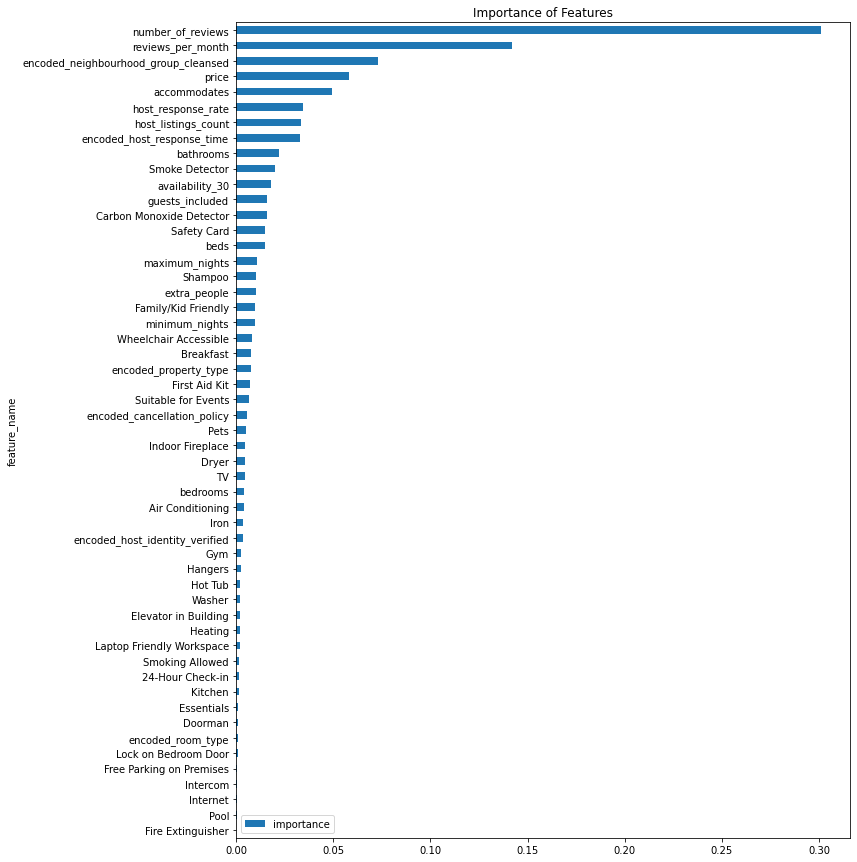

In [ ]:
rf_classifier_feature_importance.sort_values(by='importance',ascending = True).plot.barh(x='feature_name',y='importance',title = 'Importance of Features',figsize=(11,15))

#### MultiLayer Perceptron Classifier

In [ ]:

mlp_cols = ['host_response_rate','host_listings_count','accommodates','bathrooms','bedrooms','beds','guests_included',
            'extra_people','minimum_nights','maximum_nights','availability_30','number_of_reviews','reviews_per_month',
            '24-Hour Check-in', 'Air Conditioning', 'Breakfast', 'Carbon Monoxide Detector', 'Doorman', 'Dryer', 'Elevator in Building', 'Essentials', 'Family/Kid Friendly', 
            'Fire Extinguisher', 'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Intercom', 'Internet', 
            'Iron', 'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door', 'Pets', 'Pool', 'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed', 
            'Suitable for Events', 'TV', 'Washer', 'Wheelchair Accessible','price',
            'encoded_host_response_time','encoded_neighbourhood_group_cleansed','encoded_host_identity_verified',
            'encoded_property_type','encoded_room_type','encoded_cancellation_policy']

third_pipe = Pipeline(stages=[
    hrt_num,ngc_num,hiv_num,pt_num,rt_num,cp_num,
    feature.VectorAssembler(inputCols=mlp_cols, 
                            outputCol='features',handleInvalid='skip')
])

In [ ]:
layers = [53, 8, 2]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='host_is_superhost01', layers = layers, seed =1)

mlp_pipe = Pipeline(stages=[third_pipe, mlp])

mlp_pipe_model_fitted = mlp_pipe.fit(training_df)

In [ ]:
pred_df = mlp_pipe_model_fitted.transform(validation_df)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol=mlp.getLabelCol(), rawPredictionCol=mlp.getRawPredictionCol(), metricName='areaUnderROC')
mlpacc = evaluator.evaluate(pred_df)
print("AUC OF MULTILAYERPERCEPTRON MODEL : ",mlpacc)

AUC OF MULTILAYERPERCEPTRON MODEL :  0.6929158032082278


In [ ]:
mlp_model_mse_compare = pd.DataFrame(list(zip(['MLPC'], [mlpacc])),
            columns = ['Model','Validation AUC'])
mlp_model_mse_compare

,Model,Validation AUC
0,MLPC,0.692916


### Overall Best Features for Growth of Airbnb

In [ ]:
result = rf_classifier_feature_importance.join(best_rf_feature_importance.set_index('feature_name'),
    how='outer', on=['feature_name'], 
)
result['overall importance'] = result.importance+result.weight

result.sort_values(by=['overall importance', 'weight', 'importance'], ascending=False).reset_index()[['feature_name', 'overall importance']].head(15)

,feature_name,overall importance
0,number_of_reviews,0.348774
1,accommodates,0.207373
2,bedrooms,0.165101
3,bathrooms,0.157608
4,encoded_neighbourhood_group_cleansed,0.107177
5,encoded_room_type,0.082361
6,beds,0.079379
7,host_listings_count,0.077842
8,encoded_host_response_time,0.055052
9,guests_included,0.054591
